In [1]:
# Required libraries
import os
import math
import pims
from natsort import natsorted
import torch
import torch.nn as nn
from torch import Tensor
import random
import cv2 as cv
import numpy as np
import pandas as pd
import skimage as ski
from PIL import Image
import statistics
from PIL.ExifTags import TAGS
import matplotlib.pyplot as plt
from typing import Any, Callable, List, Optional, Type, Union
from tqdm import tqdm # for calculating mean, stdev (https://kozodoi.me/blog/20210308/compute-image-stats)
from itertools import islice # for taking first n elements from an iterable (dataloader object)
from torchinfo import summary
import wandb

from torch.utils.data import Dataset, DataLoader, random_split

from torchvision.models import resnet101, ResNet101_Weights, resnet50, ResNet50_Weights
from torchvision.io import read_image
from torchvision.utils import save_image
from torch.utils.checkpoint import checkpoint
from torchvision.transforms import v2 as transforms

from transformers import AutoModel

from pythae.models import AE, AEConfig, AutoModel
from pythae.trainers import BaseTrainerConfig
from pythae.pipelines.training import TrainingPipeline
from pythae.models.nn.benchmarks.celeba import Encoder_ResNet_AE_CELEBA, Decoder_ResNet_AE_CELEBA, Encoder_Conv_AE_CELEBA, Decoder_Conv_AE_CELEBA, Encoder_ResNet_VAE_CELEBA
from pythae.data.datasets import DatasetOutput
from pythae.samplers import NormalSampler
from pythae.trainers.training_callbacks import WandbCallback

os.environ['WANDB_TIMEOUT'] = '120'
os.environ['JAVA_HOME'] = '/hps/nobackup/birney/users/esther/Fiji.app/java/linux-amd64/zulu8.60.0.21-ca-fx-jdk8.0.322-linux_x64/jre/'

In [2]:
! module load cuda/12.2.0

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.version.cuda)

12.1


In [4]:
torch.manual_seed(1)

In [5]:
# Set working directory
os.chdir('/nfs/research/birney/users/esther/medaka-img/src_files/')

In [279]:
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ey267 (ey267-university-of-cambridge). Use `wandb login --relogin` to force relogin


True

## Load medaka data

In [39]:
# Custom min-max scaling function to pass into Compose; transforms pixel values to range [0,1] for each image individually
class MinMaxScaling:
    def __call__(self, tensor):
        return (tensor - tensor.min()) / (tensor.max() - tensor.min())

In [40]:
# Compose image transformations
# Based on testing below, MinMax scaling is the best normalization method for this dataset
# Using mean and std of the dataset for normalization is maybe not representative of the entire dataset,
# as the maximum value after normalization is 431.33228 (eg. subtracting the max pixel value, )
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda img: transforms.functional.crop(img, 0, 0, 980, 1392)), # crop out bottom text
    transforms.Resize((224, 224)),
    # transforms.Resize((979, 979)), # resize to 979x979 to give 490x490 after first conv
    # transforms.RandomCrop(64), # crop to 64x64
    # transforms.Normalize(mean=(0, 0, 0), std=(1, 1, 1)) # temporarily, to get the mean and stdev of the dataset
    # transforms.Normalize(mean=(0.035028, 0.000052371, 0.00043022), std=(0.0600, 0.0013, 0.0028))
    # transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # imagenet normalization -> returns black images
    MinMaxScaling() # custom normalization
])

/hps/software/users/birney/esther/micromamba/envs/indigene-img/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Flip all left-facing images to the right within the MedakaDataset class

In [38]:
# Read in dataframe indicating whether the fish is facing left or right
fish_direction_df= pd.read_csv("/nfs/research/birney/users/esther/medaka-img/scripts/left-facing-fish.csv")

# Only keep rows where the fish is facing left
fish_left_df = fish_direction_df[fish_direction_df['left_facing'] == 'left']
fish_left_df = fish_left_df.rename(columns={'Unnamed: 0': 'img_name'})

In [41]:
class MedakaDataset(Dataset):
    def __init__(self, csv_file, src_dir, transform=transform):
        # self.imgs = []
        # self.img_names = []

        self.image_paths = pd.read_csv(csv_file)['img_name']
        self.src_dir = src_dir
        self.transform = transform

        # for img_name in self.image_paths:
        #     img_path = f'{self.src_dir}/{img_name}'
        #     image = ski.io.imread(img_path)

        #     if self.transform is not None:
        #         image = self.transform(image).to(device)

        #     self.imgs.append(image)
        #     self.img_names.append(img_name)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        img_path = f'{self.src_dir}/{img_name}'
                
        image = ski.io.imread(img_path)

        # Convert to tensor, crop out bottom text, and normalize
        if self.transform is not None:
            image = self.transform(image)

        # If facing left, flip the image horizontally
        if os.path.splitext(img_name)[0] in fish_left_df['img_name'].values:
            image = transforms.functional.hflip(image)

        return image.to(device), img_name

In [264]:
# Load datasets
dataset = MedakaDataset(csv_file='train_set_2024-10-03.csv', 
                                src_dir='/nfs/research/birney/users/esther/medaka-img/src_files/train_2024-10-03/raw_images', 
                                transform=transform)
test_dataset = MedakaDataset(csv_file='test_set_2024-10-03 copy.csv',
                                src_dir='/nfs/research/birney/users/esther/medaka-img/src_files/test_2024-10-03/raw_images',
                                transform=transform)

train_loader = DataLoader(dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [48]:
train_len = int(len(dataset) * 0.8)
val_len = len(dataset) - train_len

train_dataset, val_dataset = random_split(dataset, [train_len, val_len])

print(f"Train length: {train_len}")
print(f"Validation length: {val_len}")

Train length: 889
Validation length: 223


torch.Size([3, 224, 224])


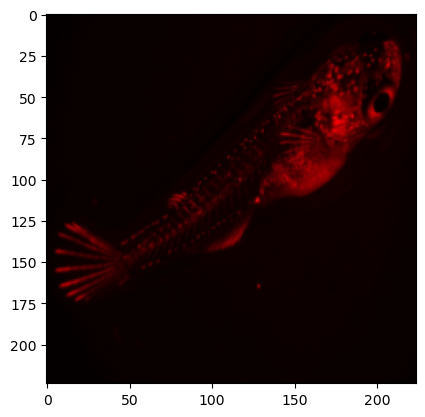

In [49]:
train_example = train_dataset[393]

print(train_example[0].shape)
plt.imshow(train_example[0].permute(1, 2, 0).cpu().numpy())

Load pretrained ResNet

In [23]:
weights = ResNet50_Weights.DEFAULT

resnet = resnet50(weights=weights)

In [24]:
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [104]:
resnet.eval()

out = resnet(train_example[0].unsqueeze(0))

Lol ResNet101 says that it's a goldfish

In [105]:
prediction = out.squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
print(f"{category_name}: {100 * score:.1f}%")

goldfish: 23.7%


In [79]:
summary(resnet, (1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         (9,408)
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         (128)
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           (4,096)
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]    

## Create Decoder Network

In [9]:
# From PyTorch documentation: https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [8]:
# From PyTorch documentation: https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py
class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [10]:
# From PyTorch documentation: https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py
class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition" https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [ ]:
# From pythae: https://github.com/clementchadebec/benchmark_VAE/blob/6419e21558f2a6abc2da99944bddda846ded30f4/src/pythae/models/nn/benchmarks/utils.py#L5
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        nn.Module.__init__(self)

        self.conv_block = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, in_channels, kernel_size=1, stride=1, padding=0),
        )

    def forward(self, x: torch.tensor) -> torch.Tensor:
        return x + self.conv_block(x)

In [181]:
class ResNet_Decoder(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        # _log_api_usage_once(self)
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.upsample0 = nn.Upsample((7, 7), mode='bilinear', align_corners=True)
        self.layer0 = nn.ConvTranspose2d(in_channels=2048, out_channels=1024, kernel_size=3, stride=2, padding = 1, output_padding=1, bias=False)
        self.layer1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding = 1, output_padding=1, bias=False)
        self.layer2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding = 1, output_padding=1, bias=False)
        self.layer3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding = 1, output_padding=1, bias=False)
        self.layer4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding = 1, output_padding=1, bias=False)
        # output padding must be smaller than either stride or dilation, but got output_padding_height: 1 output_padding_width: 1 stride_height: 1 stride_width: 1 dilation_height: 1 dilation_width: 1
        self.layer5 = nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=1, dilation = 3, stride=1, padding = 1, output_padding=2, bias=False)
        # self.layer1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=0, bias=False)
        # self.layer2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=0, bias=False)
        # self.fc = nn.Linear(in_features=1, out_features=2048, bias=True)
        # self.conv0 = nn.ConvTranspose2d(in_channels=1, out_channels=, kernel_size=3, stride=1, padding=0, dilation=2, bias=False)
        # self.interpolate = nn.functional.interpolate(input = self.fc, size = (512, 2048), mode = 'bilinear', align_corners = False)
        # self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        # self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        # self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        # self.layer1 = self._make_layer(block, 64, layers[0])
        # self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.relu = nn.ReLU(inplace=True)
        # self.bn1 = norm_layer(self.inplanes)
        # self.conv1 = nn.ConvTranspose2d(self.inplanes, 3, kernel_size=7, stride=2, padding=3, padding = 1, output_padding=1, bias=False)
        # # add self.sigmoid
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.upsample0(x)
        # x = self.fc(x)
        # x = self.conv0(x)
        x = self.layer0(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)
        x = self.relu(x)
        x = self.layer4(x)
        x = self.relu(x)
        x = self.layer5(x)
        x = self.relu(x)
        # x = self.upsample(x)
        # x = self.relu(x)
        # x = self.bn1(x)
        # x = self.conv1(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

In [182]:
resnet_decoder = ResNet_Decoder(BasicBlock, [3, 4, 6, 3])

summary(resnet_decoder, (1, 2048, 1, 1))
# resnet_decoder.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet_Decoder                           [1, 3, 224, 224]          --
├─Upsample: 1-1                          [1, 2048, 7, 7]           --
├─ConvTranspose2d: 1-2                   [1, 1024, 14, 14]         18,874,368
├─ReLU: 1-3                              [1, 1024, 14, 14]         --
├─ConvTranspose2d: 1-4                   [1, 512, 28, 28]          4,718,592
├─ReLU: 1-5                              [1, 512, 28, 28]          --
├─ConvTranspose2d: 1-6                   [1, 256, 56, 56]          1,179,648
├─ReLU: 1-7                              [1, 256, 56, 56]          --
├─ConvTranspose2d: 1-8                   [1, 128, 112, 112]        294,912
├─ReLU: 1-9                              [1, 128, 112, 112]        --
├─ConvTranspose2d: 1-10                  [1, 64, 224, 224]         73,728
├─ReLU: 1-11                             [1, 64, 224, 224]         --
├─ConvTranspose2d: 1-12                  [1, 3, 224, 2

ResNet18: [2, 2, 2, 2]
ResNet34: [3, 4, 6, 3]
ResNet50: [3, 4, 6, 3]
ResNet101: [3, 4, 23, 3]
ResNet152: [3, 8, 36, 3]

## Create encoder-decoder model

In [184]:
# Remove last layer of ResNet
resnet_temp = nn.Sequential(*list(resnet.children())[:-1])

summary(resnet_temp, (1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 2048, 1, 1]           --
├─Conv2d: 1-1                            [1, 64, 112, 112]         (9,408)
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         (128)
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           (4,096)
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]    

In [185]:
class ResNetAE(nn.Module):
    def __init__(self, modelA, modelB):
        super(ResNetAE, self).__init__()
        self.encoder = resnet_temp
        self.decoder = resnet_decoder
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Freeze and train the model

In [187]:
# Freeze the pretrained weights of the encoder
resnet_temp.requires_grad_(False)

resnet_ae = ResNetAE(resnet_temp, resnet_decoder)

summary(resnet_ae, (1, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
ResNetAE                                      [1, 3, 224, 224]          --
├─Sequential: 1-1                             [1, 2048, 1, 1]           --
│    └─Conv2d: 2-1                            [1, 64, 112, 112]         (9,408)
│    └─BatchNorm2d: 2-2                       [1, 64, 112, 112]         (128)
│    └─ReLU: 2-3                              [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [1, 64, 56, 56]           --
│    └─Sequential: 2-5                        [1, 256, 56, 56]          --
│    │    └─Bottleneck: 3-1                   [1, 256, 56, 56]          (75,008)
│    │    └─Bottleneck: 3-2                   [1, 256, 56, 56]          (70,400)
│    │    └─Bottleneck: 3-3                   [1, 256, 56, 56]          (70,400)
│    └─Sequential: 2-6                        [1, 512, 28, 28]          --
│    │    └─Bottleneck: 3-4                   [1, 512, 28, 28]       

In [206]:
resnet_ae.train().to(device)

ResNetAE(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64,

In [281]:
def get_batch_accuracy(output, y, N):
    zero_tensor = torch.tensor([0]).to(device)
    pred = torch.gt(output, zero_tensor)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / N

train_N = train_len
valid_N = val_len

model = resnet_ae.to(device)
learning_rate = 0.001
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(resnet_ae.parameters(), lr=learning_rate)

In [219]:
random_trans = transforms.Compose([
    transforms.RandomRotation(45)
])

In [285]:
def train(model, check_grad=False):
    loss = 0
    accuracy = 0

    model.train()
    for img, img_name in train_loader:
        # print(x.shape)
        output = torch.squeeze(model(random_trans(img)))
        optimizer.zero_grad()
        # print(output.shape)
        batch_loss = loss_function(output, img)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        # accuracy += get_batch_accuracy(output, img, train_N)
    if check_grad:
        print('Last Gradient:')
        for param in model.parameters():
            print(param.grad)
    print('Train - Loss: {:.4f}'.format(loss))
    wandb.log({"Train - Loss": loss})

In [ ]:
train(model, check_grad=True)

In [286]:
def validate(model):
    loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
        for img, img_name in test_loader:
            # print(img_name)
            output = torch.squeeze(model(img))

            loss += loss_function(output, img).item()
            # accuracy += get_batch_accuracy(output, img, valid_N)
    print('Valid - Loss: {:.4f}'.format(loss))
    wandb.log({"Valid - Loss": loss})

In [283]:
config = dict(
    epochs=100,
    kernels=[16, 32],
    batch_size=4,
    learning_rate=learning_rate,
    dataset="medaka-img-2024-10-03",
    architecture="Pretrained ResNet50, custom decoder")


In [290]:
epochs = 200

wandb.init(config = config, project="resnet-pytorch-medaka")

for epoch in range(epochs):
    wandb.watch(model)
    print('Epoch: {}'.format(epoch))
    train(model, check_grad=False)
    validate(model)
    if epoch == epochs - 1:
        torch.save(model.state_dict(), f"resnet_ae_{epoch}.pth")

Train - Loss,▇█▆▄▄▅▅▅▄▆▄▄▄▅▅▃▃▆▃▃▃▃▃▄▄▁▂▂▃▃▃▄▄▁▃▂▂▂▁▃
Valid - Loss,▃▁█▁▂▂▁▄▁▁▁▂▂▂▃▁▁▁▁▂▁▂▂▁█▂▁▁▁▁▁▂▂▁▁▂▂▃▁▁
Train - Loss,0.77028
Valid - Loss,0.70957


Epoch: 0
Train - Loss: 0.7687
Valid - Loss: 0.7154
Epoch: 1
Train - Loss: 0.7688
Valid - Loss: 0.7300
Epoch: 2
Train - Loss: 0.7681
Valid - Loss: 0.7104
Epoch: 3
Train - Loss: 0.7676
Valid - Loss: 0.7115
Epoch: 4
Train - Loss: 0.7704
Valid - Loss: 0.7232
Epoch: 5
Train - Loss: 0.7688
Valid - Loss: 0.7195
Epoch: 6
Train - Loss: 0.7689
Valid - Loss: 0.7108
Epoch: 7
Train - Loss: 0.7691
Valid - Loss: 0.7081
Epoch: 8
Train - Loss: 0.7687
Valid - Loss: 0.7339
Epoch: 9
Train - Loss: 0.7688
Valid - Loss: 0.7218
Epoch: 10
Train - Loss: 0.7688
Valid - Loss: 0.7097
Epoch: 11
Train - Loss: 0.7684
Valid - Loss: 0.7232
Epoch: 12
Train - Loss: 0.7687
Valid - Loss: 0.7206
Epoch: 13
Train - Loss: 0.7691
Valid - Loss: 0.7283
Epoch: 14
Train - Loss: 0.7681
Valid - Loss: 0.7096
Epoch: 15
Train - Loss: 0.7684
Valid - Loss: 0.7260
Epoch: 16
Train - Loss: 0.7686
Valid - Loss: 0.7212
Epoch: 17
Train - Loss: 0.7686
Valid - Loss: 0.7142
Epoch: 18
Train - Loss: 0.7693
Valid - Loss: 0.7100
Epoch: 19
Train - Loss

In [288]:
model.eval()

train_example = train_dataset[393]
out = model(train_example[0].unsqueeze(0))

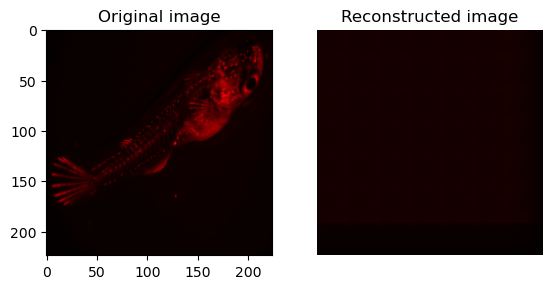

In [289]:
fig, axs = plt.subplots(1,2)

axs[0].imshow(train_example[0].permute(1, 2, 0).cpu().numpy())
axs[0].set_title('Original image')

axs[1].imshow(out.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
axs[1].set_title('Reconstructed image')
axs[1].axis('off')

plt.show()

In [223]:
# Training loop
def train(model, train_loader, val_loader, epochs, optimizer, loss_function):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader):
            inputs = data[0].unsqueeze(0)
            # print(inputs.shape) 
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, inputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 2000 == 1999:
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 2000}")
                running_loss = 0.0
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for i, data in enumerate(val_loader):
                inputs = data[0].unsqueeze(0)
                outputs = model(inputs)
                val_loss = loss_function(outputs, inputs)
                # val_loss += loss.item()
                val_loss += loss_function(outputs, inputs)
            print(f"Validation loss: {val_loss / len(val_loader)}")
    print("Finished training")

In [ ]:
train(resnet_ae, train_dataset, val_dataset, 20, torch.optim.Adam(resnet_ae.parameters(), lr = 0.01), nn.MSELoss())

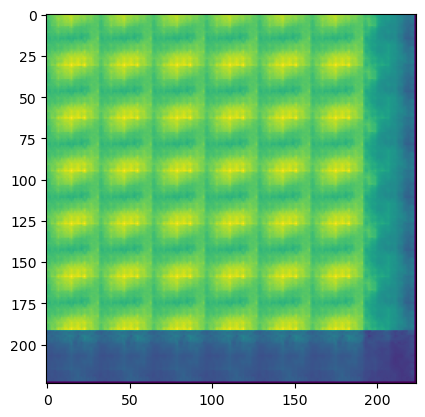

In [204]:
plt.imshow(out.squeeze(0).permute(1, 2, 0)[:,:,0].cpu().detach().numpy())

In [199]:
train_example = train_dataset[393]

print(train_example[0].shape)
plt.imshow(out.unsqueeze(0).permute(1, 2, 0).cpu().numpy())

torch.Size([3, 224, 224])


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 5 is not equal to len(dims) = 3